In [1]:
import numpy as np

In [2]:
from collections import defaultdict

In [3]:
data_path = 'desktop/ml-10M100K/ratings.dat'

In [4]:
n_users = 71567
n_movies = 10681

In [5]:
def load_rating_data(data_path, n_users, n_movies):
    """
    Load rating data from file and also return the number of ratings for each movie and movie_id index mapping
    @param data_path: path of the rating data file
    @param n_users: number of users
    @param n_movies: number of movies that have ratings
    @return: rating data in the numpy array of [user, movie]; movie_n_rating, {movie_id: number of ratings};
             movie_id_mapping, {movie_id: column index in rating data}
    """
    data = np.zeros([n_users, n_movies], dtype=np.float32)
    movie_id_mapping = {}
    movie_n_rating = defaultdict(int)
    with open(data_path, 'r') as file:
        for line in file.readlines()[1:]:
            user_id, movie_id, rating, _ = line.split("::")
            user_id = int(user_id) - 1
            if movie_id not in movie_id_mapping:
                movie_id_mapping[movie_id] = len(movie_id_mapping)
            rating = int(float(rating))
            data[user_id, movie_id_mapping[movie_id]] = rating
            if rating > 0:
                movie_n_rating[movie_id] += 1
    return data, movie_n_rating, movie_id_mapping

In [6]:
data, movie_n_rating, movie_id_mapping = load_rating_data(data_path, n_users, n_movies)

In [8]:
def display_distribution(data):
    values, counts = np.unique(data, return_counts=True)
    for value, count in zip(values, counts):
        print(f'Number of rating {int(value)}: {count}')

In [9]:
display_distribution(data)

Number of rating 0: 754502062
Number of rating 1: 502458
Number of rating 2: 1160484
Number of rating 3: 3236440
Number of rating 4: 3460872
Number of rating 5: 1544811


In [10]:
movie_id_most, n_rating_most = sorted(movie_n_rating.items(), key=lambda d: d[1], reverse=True)[0]

print(f'Movie ID {movie_id_most} has {n_rating_most} ratings.')

Movie ID 296 has 34756 ratings.


In [11]:
X_raw = np.delete(data, movie_id_mapping[movie_id_most], axis=1)
Y_raw = data[:, movie_id_mapping[movie_id_most]]

In [12]:
X_raw.shape

(71567, 10680)

In [13]:
X = X_raw[Y_raw > 0]
Y = Y_raw[Y_raw > 0]

print('Shape of X:', X.shape)
print('Shape of Y:', Y.shape)

display_distribution(Y)


Shape of X: (34756, 10680)
Shape of Y: (34756,)
Number of rating 1: 1030
Number of rating 2: 1388
Number of rating 3: 5476
Number of rating 4: 11889
Number of rating 5: 14973


In [14]:
recommend = 3
Y[Y <= recommend] = 0
Y[Y > recommend] = 1

In [15]:
n_pos = (Y == 1).sum()
n_neg = (Y == 0).sum()
print(f'{n_pos} positive samples and {n_neg} negative samples.')


26862 positive samples and 7894 negative samples.


In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(len(Y_train), len(Y_test))

27804 6952


In [17]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=1.0, fit_prior=True)
clf.fit(X_train, Y_train)


MultinomialNB()

In [18]:
prediction_prob = clf.predict_proba(X_test)
print(prediction_prob[0:10])

[[1.42206797e-12 1.00000000e+00]
 [1.33502332e-31 1.00000000e+00]
 [9.99223787e-01 7.76213294e-04]
 [1.08495315e-16 1.00000000e+00]
 [6.17403325e-05 9.99938260e-01]
 [9.99999961e-01 3.85937752e-08]
 [1.42256921e-42 1.00000000e+00]
 [1.46517456e-17 1.00000000e+00]
 [1.61249328e-22 1.00000000e+00]
 [4.41258271e-95 1.00000000e+00]]


In [19]:
prediction = clf.predict(X_test)
print(prediction[:10])

[1. 1. 0. 1. 1. 0. 1. 1. 1. 1.]


In [20]:
accuracy = clf.score(X_test, Y_test)
print(f'The accuracy is: {accuracy*100:.1f}%')

The accuracy is: 60.1%


In [21]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test, prediction, labels=[0, 1]))

[[ 983  521]
 [2256 3192]]


In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_score(Y_test, prediction, pos_label=1)


0.8596821976838136

In [23]:
recall_score(Y_test, prediction, pos_label=1)

0.5859030837004405

In [24]:
f1_score(Y_test, prediction, pos_label=0)

0.41450558718110897

In [25]:
from sklearn.metrics import classification_report
report = classification_report(Y_test, prediction)
print(report)

              precision    recall  f1-score   support

         0.0       0.30      0.65      0.41      1504
         1.0       0.86      0.59      0.70      5448

    accuracy                           0.60      6952
   macro avg       0.58      0.62      0.56      6952
weighted avg       0.74      0.60      0.64      6952



In [26]:
pos_prob = prediction_prob[:, 1]

In [27]:
pos_prob

array([1.00000000e+00, 1.00000000e+00, 7.76213294e-04, ...,
       9.90646503e-01, 2.72819931e-11, 1.00000000e+00])

In [28]:
prediction_prob

array([[1.42206797e-12, 1.00000000e+00],
       [1.33502332e-31, 1.00000000e+00],
       [9.99223787e-01, 7.76213294e-04],
       ...,
       [9.35349687e-03, 9.90646503e-01],
       [1.00000000e+00, 2.72819931e-11],
       [5.35009561e-22, 1.00000000e+00]])

In [29]:
thresholds = np.arange(0.0, 1.1, 0.05)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05])

In [30]:
true_pos, false_pos = [0]*len(thresholds), [0]*len(thresholds)

In [31]:
zip(pos_prob, Y_test)

In [32]:
for pred, y in zip(pos_prob, Y_test):
        for i, threshold in enumerate(thresholds):
            if pred >= threshold:
                if y == 1:
                    true_pos[i] += 1
                else:
                    false_pos[i] += 1
            else:
                break


In [33]:
n_pos_test = (Y_test == 1).sum()
n_neg_test = (Y_test == 0).sum()

In [34]:
n_pos_test

5448

In [35]:
n_neg_test

1504

In [36]:
true_pos_rate = [tp / n_pos_test for tp in true_pos]
false_pos_rate = [fp / n_neg_test for fp in false_pos]

In [37]:
true_pos_rate

[1.0,
 0.6018722466960352,
 0.5983847283406755,
 0.5969162995594713,
 0.5943465491923642,
 0.592143906020558,
 0.5899412628487518,
 0.5897577092511013,
 0.5888399412628488,
 0.5875550660792952,
 0.5859030837004405,
 0.5838839941262849,
 0.5835168869309838,
 0.5827826725403817,
 0.5820484581497798,
 0.5807635829662261,
 0.5798458149779736,
 0.5780102790014684,
 0.5747063142437592,
 0.57140234948605,
 0.40767254038179146,
 0.0]

In [38]:
false_pos_rate

[1.0,
 0.3617021276595745,
 0.35771276595744683,
 0.3537234042553192,
 0.35305851063829785,
 0.35305851063829785,
 0.3490691489361702,
 0.3484042553191489,
 0.34773936170212766,
 0.3470744680851064,
 0.3464095744680851,
 0.34507978723404253,
 0.34441489361702127,
 0.34375,
 0.34175531914893614,
 0.3404255319148936,
 0.3390957446808511,
 0.3377659574468085,
 0.33643617021276595,
 0.324468085106383,
 0.19414893617021275,
 0.0]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


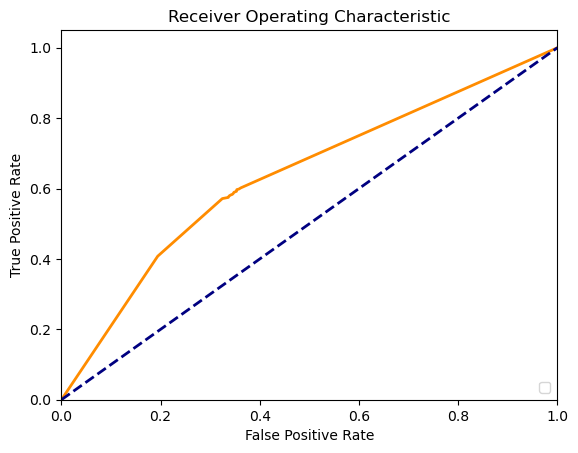

In [39]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(false_pos_rate, true_pos_rate, color='darkorange', lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [40]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(Y_test, pos_prob))

0.6557523671579655


In [41]:
from sklearn.model_selection import StratifiedKFold
k = 5
k_fold = StratifiedKFold(n_splits=k, random_state=42, shuffle = True)

smoothing_factor_option = [1, 2, 3, 4, 5, 6]
fit_prior_option = [True, False]
auc_record = {}

In [42]:
for train_indices, test_indices in k_fold.split(X, Y):
    X_train, X_test = X[train_indices], X[test_indices]
    Y_train, Y_test = Y[train_indices], Y[test_indices]
    for alpha in smoothing_factor_option:
        if alpha not in auc_record:
            auc_record[alpha] = {}
        for fit_prior in fit_prior_option:
            clf = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
            clf.fit(X_train, Y_train)
            prediction_prob = clf.predict_proba(X_test)
            pos_prob = prediction_prob[:, 1]
            auc = roc_auc_score(Y_test, pos_prob)
            auc_record[alpha][fit_prior] = auc + auc_record[alpha].get(fit_prior, 0.0)

In [43]:
auc_record

{1: {True: 3.3151160244841673, False: 3.3162974974257624},
 2: {True: 3.317160319179175, False: 3.318645885336373},
 3: {True: 3.3176370928001977, False: 3.319863757888339},
 4: {True: 3.317101019130013, False: 3.319163666432667},
 5: {True: 3.3179501559987354, False: 3.3185818997346987},
 6: {True: 3.317041758259619, False: 3.319202531270159}}

In [44]:
print('smoothing  fit prior  auc')
for smoothing, smoothing_record in auc_record.items():
    for fit_prior, auc in smoothing_record.items():
        print(f'    {smoothing}        {fit_prior}    {auc/k:.5f}')

smoothing  fit prior  auc
    1        True    0.66302
    1        False    0.66326
    2        True    0.66343
    2        False    0.66373
    3        True    0.66353
    3        False    0.66397
    4        True    0.66342
    4        False    0.66383
    5        True    0.66359
    5        False    0.66372
    6        True    0.66341
    6        False    0.66384


In [45]:
clf = MultinomialNB(alpha=3.0, fit_prior=False)
clf.fit(X_train, Y_train)

pos_prob = clf.predict_proba(X_test)[:, 1]
print('AUC with the best model:', roc_auc_score(Y_test, pos_prob))

AUC with the best model: 0.657577423803994
